# Spotify Genre Classifier

## Setup

In [94]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk, path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy import stats
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

In [2]:
# load data

# get all filenames from the directory data
f = []
for (dirpath, dirnames, filenames) in walk("data"):
    f.extend(filenames)
    break

# load data from all files from the directory data
frames = []
for file in f:
    data = pd.read_json(path.join("data", file))
    frames.append(data)

# concat all data into one dataframe
raw_data = pd.concat(frames, ignore_index=True)

## Visualization

### Clean Dataset

In [3]:
raw_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0.1930,0.11600,9,-25.718,1,0.0608,0.986,0.91800,0.5050,0.0836,143.301,audio_features,6pV1dGidc6DvzjKhbMqgDa,spotify:track:6pV1dGidc6DvzjKhbMqgDa,https://api.spotify.com/v1/tracks/6pV1dGidc6Dv...,https://api.spotify.com/v1/audio-analysis/6pV1...,242467,3,classic
1,0.3210,0.00611,4,-38.341,0,0.0362,0.995,0.90800,0.0900,0.0693,104.311,audio_features,1YcABWwgkfrOSw8VMgDWZU,spotify:track:1YcABWwgkfrOSw8VMgDWZU,https://api.spotify.com/v1/tracks/1YcABWwgkfrO...,https://api.spotify.com/v1/audio-analysis/1YcA...,205493,4,classic
2,0.4480,0.00520,4,-36.512,1,0.0564,0.995,0.88000,0.0698,0.0398,62.171,audio_features,1juisCcrVdwoLbDWyVvNrX,spotify:track:1juisCcrVdwoLbDWyVvNrX,https://api.spotify.com/v1/tracks/1juisCcrVdwo...,https://api.spotify.com/v1/audio-analysis/1jui...,369027,4,classic
3,0.4250,0.03630,1,-21.629,0,0.0686,0.991,0.00109,0.2500,0.7450,78.991,audio_features,1AKdBq4wtJKU9DhQpekvtc,spotify:track:1AKdBq4wtJKU9DhQpekvtc,https://api.spotify.com/v1/tracks/1AKdBq4wtJKU...,https://api.spotify.com/v1/audio-analysis/1AKd...,143777,4,classic
4,0.0748,0.04420,0,-19.183,1,0.0426,0.957,0.94000,0.1160,0.0369,79.092,audio_features,5X5x6oRSCHtHEz28ncMVd5,spotify:track:5X5x6oRSCHtHEz28ncMVd5,https://api.spotify.com/v1/tracks/5X5x6oRSCHtH...,https://api.spotify.com/v1/audio-analysis/5X5x...,348907,4,classic


In [6]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre'],
      dtype='object')

In [4]:
# now drop some features which have no importance for the ML task
raw_data.drop(["uri", "id", "track_href", "analysis_url", "type"], axis=1, inplace=True)

In [9]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre'],
      dtype='object')

In [10]:
raw_data.shape

(1515, 14)

In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1515 non-null   float64
 1   energy            1515 non-null   float64
 2   key               1515 non-null   int64  
 3   loudness          1515 non-null   float64
 4   mode              1515 non-null   int64  
 5   speechiness       1515 non-null   float64
 6   acousticness      1515 non-null   float64
 7   instrumentalness  1515 non-null   float64
 8   liveness          1515 non-null   float64
 9   valence           1515 non-null   float64
 10  tempo             1515 non-null   float64
 11  duration_ms       1515 non-null   int64  
 12  time_signature    1515 non-null   int64  
 13  genre             1515 non-null   object 
dtypes: float64(9), int64(4), object(1)
memory usage: 165.8+ KB


In [5]:
# remove samples with key == -1
befor = len(raw_data)
raw_data = raw_data[raw_data.key != -1]
print(f"Removed samples: {befor - len(raw_data)}")

Removed samples: 0


In [6]:
len(raw_data)

1515

In [7]:
# remove samples where time_signature is out of bounds [3:7]
befor = len(raw_data)
raw_data = raw_data[(raw_data.time_signature >= 3) & (raw_data.time_signature <= 7)]
print(f"Removed samples: {befor - len(raw_data)}")

Removed samples: 19


In [8]:
raw_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1.496000e+03,1496.000000
mean,0.518864,0.576181,5.324866,-10.743261,0.554813,0.101637,0.359781,0.244451,0.181888,0.405590,118.611152,2.726669e+05,3.922460
std,0.209155,0.328465,3.553143,8.596414,0.497153,0.103556,0.403647,0.369033,0.143416,0.259752,31.233030,1.245252e+05,0.338208
min,0.061800,0.002090,0.000000,-44.526000,0.000000,0.025000,0.000002,0.000000,0.023400,0.027100,47.362000,8.426700e+04,3.000000
25%,0.375000,0.271750,2.000000,-14.000250,0.000000,0.040475,0.010200,0.000000,0.092575,0.167000,93.895250,1.959170e+05,4.000000
50%,0.516500,0.678000,5.000000,-7.225500,1.000000,0.052400,0.108500,0.000865,0.122000,0.387000,116.799500,2.378620e+05,4.000000
75%,0.667000,0.864000,8.000000,-4.709500,1.000000,0.112000,0.838250,0.618250,0.234250,0.616000,145.010500,3.040568e+05,4.000000
max,0.964000,0.998000,11.000000,-0.100000,1.000000,0.944000,0.996000,0.981000,0.972000,0.958000,206.247000,1.252322e+06,5.000000


In [9]:
categorical_features = {'key', 'mode', 'time_signature'}
numeric_features = set(raw_data.columns) - categorical_features - {"genre"}

numeric_features = list(numeric_features)
categorical_features = list(categorical_features)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(raw_data.iloc[:,:13], raw_data.genre, test_size=0.33, stratify=raw_data.genre)
data = {
    "x_train": x_train,
    "x_test": x_test,
    "y_train": y_train,
    "y_test": y_test,
    "features": numeric_features + categorical_features,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "target": "genre"
}

In [11]:
scaler = StandardScaler()
data["x_train"][data["numeric_features"]] = scaler.fit_transform(data["x_train"][data["numeric_features"]])
data["x_train"].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1.002000e+03,1.002000e+03,1002.000000,1.002000e+03,1002.000000,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1002.000000
mean,-6.913964e-17,-3.917913e-16,5.376248,1.524618e-16,0.555888,-1.205512e-16,4.254747e-17,8.509494e-17,-4.609309e-17,5.318434e-17,2.659217e-16,3.013779e-17,3.920160
std,1.000499e+00,1.000499e+00,3.550007,1.000499e+00,0.497115,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,0.336897
min,-2.227803e+00,-1.756108e+00,0.000000,-3.922423e+00,0.000000,-7.458863e-01,-8.860667e-01,-6.603951e-01,-1.127200e+00,-1.459677e+00,-1.910361e+00,-1.471772e+00,3.000000
25%,-6.914248e-01,-9.003287e-01,2.000000,-3.395487e-01,0.000000,-5.943966e-01,-8.606094e-01,-6.603951e-01,-6.161391e-01,-9.197668e-01,-8.018259e-01,-6.045309e-01,4.000000
50%,2.517421e-03,3.113738e-01,5.000000,3.986900e-01,1.000000,-4.736008e-01,-6.339268e-01,-6.576298e-01,-4.038084e-01,-7.651955e-02,-4.482625e-03,-2.725845e-01,4.000000
75%,7.049519e-01,8.739226e-01,8.000000,6.862650e-01,1.000000,8.582205e-02,1.190411e+00,9.886607e-01,3.778976e-01,8.226869e-01,8.343443e-01,2.336602e-01,4.000000
max,2.064933e+00,1.296984e+00,11.000000,1.228617e+00,1.000000,4.382982e+00,1.576043e+00,1.999241e+00,5.481347e+00,2.132904e+00,2.797816e+00,7.611998e+00,5.000000


### Outlier removal

In [12]:
#outlier detection using zscore
threshold = 3
filtered_data = pd.DataFrame([])
removed_cnt = 0
train_combined = data["x_train"].copy()
train_combined["genre"] = data["y_train"]

for group_name, group_data in train_combined.groupby("genre"):
    group_data = group_data.drop("genre", 1)

    z_score = group_data.select_dtypes(include='number').apply(stats.zscore)
    filter = (abs(z_score) < threshold).all(axis=1)
    group_filtered = group_data[filter]
    group_filtered['genre'] = group_name

    removed_cnt += (group_data.shape[0] - group_filtered.shape[0])
    filtered_data = pd.concat([filtered_data, group_filtered], ignore_index=False)

print(f"Removed samples: {removed_cnt}")

data["y_train"] = filtered_data["genre"]
data["x_train"] = filtered_data.drop("genre", axis=1)

Removed samples: 125


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Statistics

In [21]:
# if you want to compare statistic informations from specific features you can use: data.groupby('genre').describe()["feature1", "feature2", ...]
data["x_train"].groupby(data["y_train"]).describe()["duration_s"]

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
classic,162.0,0.413820,1.268383,-1.499311,-0.572576,0.097970,1.105898,4.128222
edm,163.0,-0.381786,0.600404,-1.248098,-0.789008,-0.577904,-0.210668,1.424702
hiphop,196.0,-0.221766,0.328145,-1.182542,-0.428285,-0.207843,-0.002187,0.634025
jazz,180.0,0.406792,1.060293,-1.245786,-0.543497,0.290348,1.113352,3.631776
rock,171.0,-0.403057,0.356118,-1.306844,-0.648876,-0.471117,-0.160180,0.498645


In [22]:
data["x_train"].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
count,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000
mean,0.027919,-0.012706,5.309633,-0.005374,0.555046,-0.039566,0.014983,-0.007340,-0.108087,0.042892,-0.014822,-0.039402,3.940367
std,1.002557,1.007757,3.531131,1.011361,0.497246,0.945119,1.011271,1.004040,0.794255,1.002832,0.978012,0.882643,0.308508
min,-2.173722,-1.740595,0.000000,-3.851202,0.000000,-0.749721,-0.900899,-0.668963,-1.107438,-1.447519,-2.306622,-1.499311,3.000000
25%,-0.645594,-0.995015,2.000000,-0.450280,0.000000,-0.599817,-0.875976,-0.668963,-0.637017,-0.870688,-0.794459,-0.639322,4.000000
50%,0.017412,0.308382,5.000000,0.415999,1.000000,-0.492813,-0.615944,-0.667283,-0.420451,-0.028837,-0.073821,-0.279197,4.000000
75%,0.717318,0.871972,8.000000,0.709766,1.000000,0.045163,1.184253,1.062178,0.181800,0.926155,0.833641,0.249947,4.000000
max,2.045711,1.285171,11.000000,1.233133,1.000000,4.108338,1.567089,1.988705,3.266586,2.076749,2.440792,4.128222,5.000000


### Plots

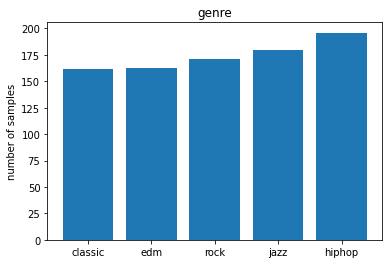

In [23]:
sorted_list = data["y_train"].value_counts().sort_values()
labels = sorted_list.index.tolist()
values = sorted_list.tolist()

plt.bar(labels, values)
plt.title("genre")
plt.ylabel("number of samples")
plt.show()

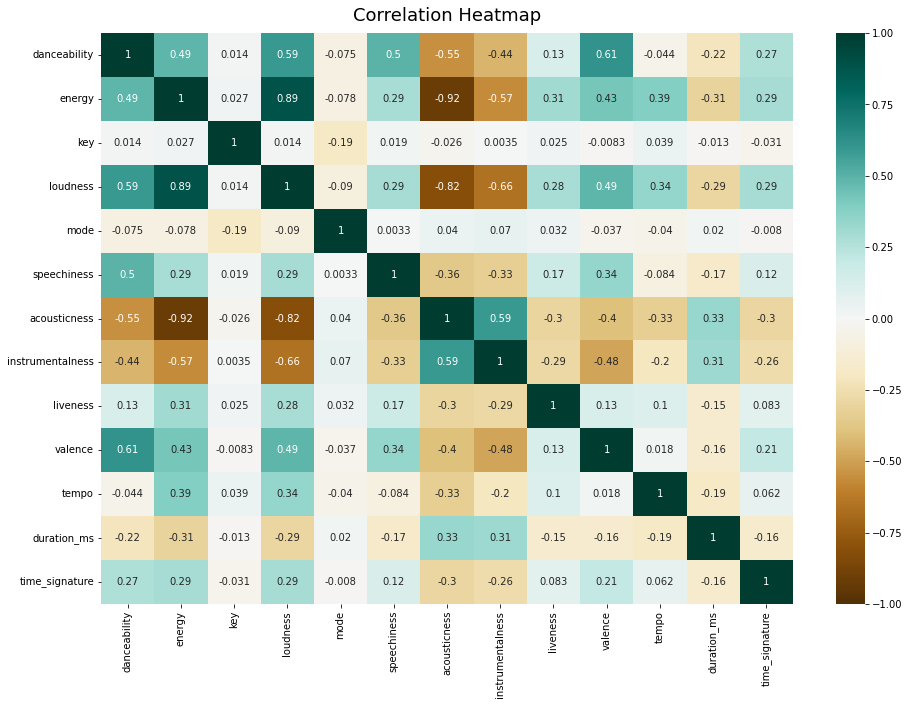

In [13]:
fig = plt.figure()
heatmap = sns.heatmap(data["x_train"].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

In [14]:
def find_correlated_features(df:pd.DataFrame, threshold:float) -> list:
    correlation_matrix = df.corr().abs()
    avg_correlation = correlation_matrix.mean(axis = 1)
    up = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
    drop = list()
        
    for row in range(len(up)-1):
        for col in range (row + 1, len(up)):
            if(correlation_matrix.iloc[row, col] >= threshold):
                if(avg_correlation.iloc[row] > avg_correlation.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop = list(set(drop)) 
    dropcols_names = list(df.columns[[item for item in drop]])
    
    return dropcols_names

Drop these correlated features: ['loudness']


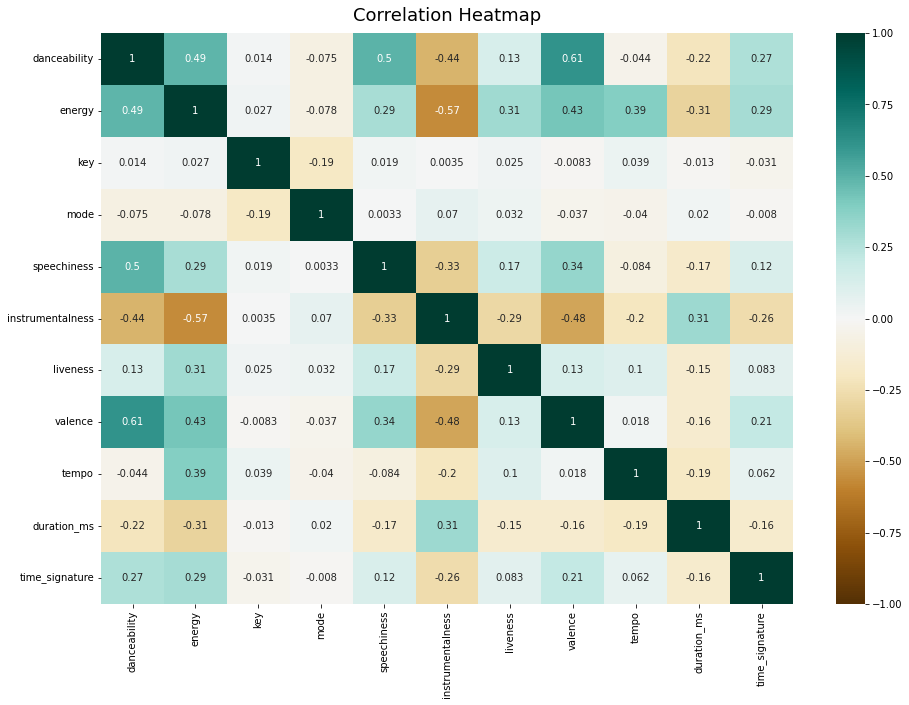

In [17]:
correlated_features = find_correlated_features(data["x_train"], .88)
print(f'Drop these correlated features: {correlated_features}')

data["x_train"].drop(correlated_features, axis=1, inplace=True)
[data["features"].remove(f) for f in correlated_features]
for feature in correlated_features:
    if feature in data["categorical_features"]:
        data["categorical_features"].remove(feature)
    if feature in data["numeric_features"]:
        data["numeric_features"].remove(feature)

fig = plt.figure()
heatmap = sns.heatmap(data["x_train"].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

In [ ]:
train_combined = data["x_train"].copy()
train_combined["genre"] = data["y_train"]
for feature in data["features"]:
    sns.boxplot(x="genre", y=feature, data=train_combined)
    plt.show()

In [ ]:
sns.pairplot(data=train_combined, hue="genre")

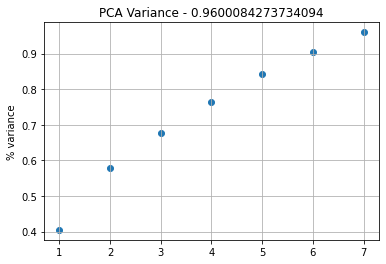

In [33]:
pca_variance_threshold = .95
pca = PCA(pca_variance_threshold)
pca.fit(data["x_train"][data["numeric_features"]])

plt.scatter(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.title(f"PCA Variance - {np.sum(pca.explained_variance_ratio_)}")
#plt.xlabel("no of PCA dimensions") # why does this throw an error...
plt.ylabel("% variance")
plt.show()

In [92]:
asdf = data["x_train"].copy()

pca_components = pca.transform(asdf[data["numeric_features"]])
cols = [f"PC{x}" for x in range(1, len(pca.explained_variance_ratio_)+1)]
asdf_pd = pd.DataFrame(pca_components, columns=cols, index=data["x_train"].index)
asdf = pd.concat([asdf_pd, asdf[data["categorical_features"]]], axis=1)
asdf

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,time_signature,key,mode
76,2.555225,-1.519268,-0.750609,-0.414433,0.973986,0.237705,1.261290,4,10,1
95,3.656142,0.963091,0.343447,0.741927,0.234896,-0.003160,-0.054440,4,11,1
181,3.352827,0.189262,-1.347959,-0.509500,-0.008716,-0.187261,0.243651,3,11,0
107,2.040822,-0.054201,-0.574076,-1.280100,0.741242,0.471434,1.074648,4,5,1
61,3.002021,-0.553030,-1.608964,-0.701053,0.316300,0.362794,0.735897,4,7,0
...,...,...,...,...,...,...,...,...,...,...
599,-0.764837,-1.441641,-0.240031,0.000010,0.368399,-0.558480,-0.479575,4,3,0
825,-0.480906,-1.424124,0.819634,0.350137,-0.224955,-0.185211,-0.073917,4,2,1
881,-1.627348,-1.236003,0.419835,0.761502,-1.397386,1.037641,0.919749,4,8,1
646,-0.443174,-1.081771,-0.332739,-0.536079,0.055674,-0.276925,-0.382951,4,9,1


## Model Selection

### Chi-square Test

<AxesSubplot:>

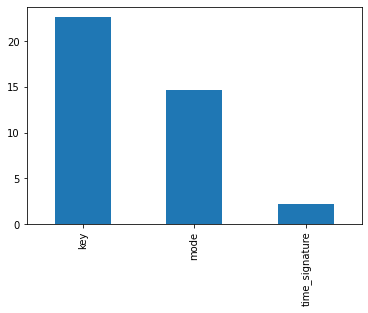

In [271]:
chi2_statistics, chi2_p_scores = chi2(data["x_train"][data["categorical_features"]], data["y_train"])
chi2_scores = pd.Series(chi2_statistics, index=data["categorical_features"])
chi2_scores.sort_values(ascending=False).plot.bar()

ANOVA f Test

<AxesSubplot:>

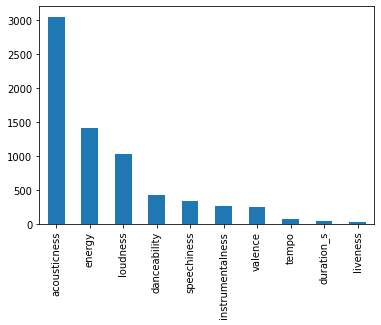

In [272]:
anova_statistics, anova_p_scores = f_classif(data["x_train"][data["numeric_features"]], data["y_train"])
anova_scores = pd.Series(anova_statistics, index=data["numeric_features"])
anova_scores.sort_values(ascending=False).plot.bar()

### Mutual Information

<AxesSubplot:>

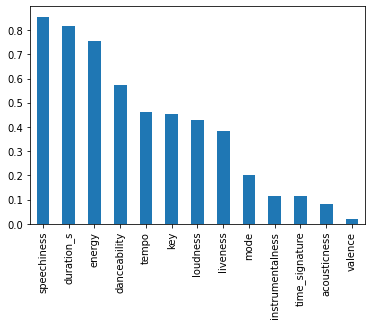

In [273]:
discrete_features_indices = [list(data["x_train"].columns).index(x) for x in data["categorical_features"]]
mutual_statistics = mutual_info_classif(data["x_train"], data["y_train"], discrete_features=discrete_features_indices)
mutual_scores = pd.Series(mutual_statistics, index=data["features"])
mutual_scores.sort_values(ascending=False).plot.bar()

<AxesSubplot:>

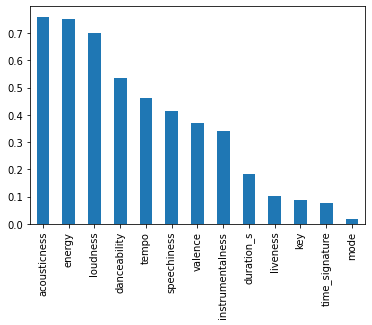

In [274]:
discrete_features_indices = [list(x_test.columns).index(x) for x in categorical_features]
mutual_statistics = mutual_info_classif(x_train, y_train, discrete_features=discrete_features_indices)
mutual_scores = pd.Series(mutual_statistics, index=x_train.columns)
mutual_scores.sort_values(ascending=False).plot.bar()

### Tree-based feature importances

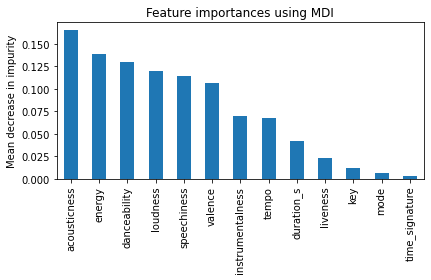

In [275]:
clf = RandomForestClassifier(n_estimators=1000)
clf = clf.fit(x_train, y_train)

forest_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Chose best features with forward feature selection

In [159]:
for i in range(1, len(data["features"])):
    svc = SVC(C=10)
    sfs_forward = SequentialFeatureSelector(
        svc, n_features_to_select=i, direction="forward"
    ).fit(data["x_train"], data["y_train"])

    feature_names = list(sfs_forward.get_feature_names_out())
    svc.fit(data["x_train"][feature_names], data["y_train"])
    print(f'No. of features: {len(feature_names)}, Features: {feature_names}, Score: {svc.score(data["x_train"][feature_names], data["y_train"])}')

No. of features: 1, Features: ['energy'], Score: 0.5849486887115165
No. of features: 2, Features: ['energy', 'speechiness'], Score: 0.7080957810718358
No. of features: 3, Features: ['energy', 'speechiness', 'valence'], Score: 0.82212086659065
No. of features: 4, Features: ['danceability', 'energy', 'speechiness', 'valence'], Score: 0.8700114025085519
No. of features: 5, Features: ['danceability', 'energy', 'speechiness', 'valence', 'tempo'], Score: 0.9201824401368301
No. of features: 6, Features: ['danceability', 'energy', 'speechiness', 'instrumentalness', 'valence', 'tempo'], Score: 0.9418472063854048
No. of features: 7, Features: ['danceability', 'energy', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'duration_ms'], Score: 0.9532497149372862
No. of features: 8, Features: ['danceability', 'energy', 'mode', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'duration_ms'], Score: 0.9578107183580388
No. of features: 9, Features: ['danceability', 'energy', 'mode', 'speechi